In [1]:
import bayesnet_alt as bn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

### Pachinko Allocation Model (PAM)

This is a semi-constrained version of the PAM -- not as constrained as the 3-layer or 4-layer PAM, since it allows an arbitrary number of layers ("$N$-layer PAM").  However, it does not yet allow an arbitrary DAG structure.

In [3]:
# Define a directed acyclic graph of topics, with exactly one source (the root), and with all leaves at the same depth (?)
g = nx.DiGraph()
g.add_edges_from([
  (0, 1),
  (0, 2),
  (1, 3),
  (1, 4),
  (1, 5),
  (2, 3),
  (2, 4),
  (2, 5),
])
g.graph["root"] = 0

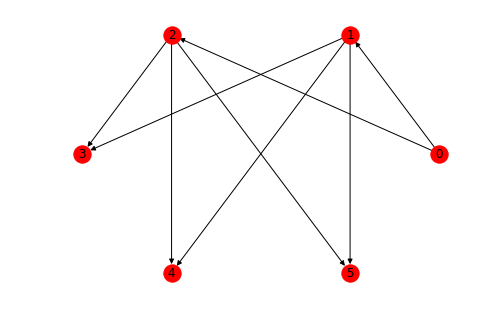

In [4]:
nx.draw_circular(g, with_labels=True)

In [5]:
def all_paths(g, start=None, prefix=()):
    if start is None:
        start = g.graph["root"]
    assert nx.algorithms.is_directed_acyclic_graph(g)
    yield prefix
    node = convert_path_to_node(g, path = prefix)
    for c in nx.neighbors(g, node):
        for p in all_paths(g, start = c, prefix = prefix + (c,)):
            yield p

def depth(g):
    depths = set()
    for p in all_paths(g):
        if num_children(g, convert_path_to_node(g, p)) == 0:
            depths.add(len(p))
    assert len(depths) == 1
    return list(depths)[0]

def convert_path_to_node(g, path):
    if len(path) == 0:
        return g.graph["root"]
    else:
        return path[-1]

def num_children(g, node):
    return len(list(nx.neighbors(g, node)))

In [6]:
list(all_paths(g))

[(), (1,), (1, 3), (1, 4), (1, 5), (2,), (2, 3), (2, 4), (2, 5)]

In [7]:
depth(g)

2

In [8]:
list(nx.neighbors(g, 0))

[1, 2]

In [9]:
m = bn.Model()
for node in g.nodes:
    nc = num_children(g, node)
    if nc == 0:
        m.add_random_variable(("alpha", node), bn.ConstantPlaceholder(shape=(bn.IndexSet("vocab"),)))
    else:
        m.add_random_variable(("alpha", node), bn.ConstantPlaceholder(shape=(nc,)))
documents_by_word_slot = bn.SymbolicMapping("word_slots", "documents", "documents_by_word_slot")

with m.loop_over("d", "documents") as d:
    for node in g.nodes:
        if num_children(g, node) > 0:
            m.add_random_variable(("theta", node, d), bn.Dirichlet(("alpha", node)))

# Bottom layer is shared across corpus
for node in g.nodes:
    if num_children(g, node) == 0:
        m.add_random_variable(("shared_theta", node), bn.Dirichlet(("alpha", node)))

def node_id(word, depth_index):
    if depth_index == 0:
        return g.graph["root"]
    else:
        return ("current_node", word, depth_index)

with m.loop_over("w", "word_slots") as w:
    m.add_random_variable(("current_doc", w), bn.Deterministic(documents_by_word_slot, args=[w]))
    for i in range(depth(g)):
        m.add_random_variable(("current_theta", w, i), bn.DeterministicLookup(("theta", bn.IndexSet("nodes"), bn.IndexSet("documents")), indices=[node_id(w, i), ("current_doc", w)]))
        m.add_random_variable(("child_index", w, i), bn.Categorical(("current_theta", w, i)))
        m.add_random_variable(("current_node", w, i+1),
            bn.Deterministic(lambda x, y: sorted(list(nx.neighbors(g, x)))[y], args=[node_id(w, i), ("child_index", w, i)]))
    m.add_random_variable(("current_theta", w, depth(g)), bn.DeterministicLookup(("shared_theta", bn.IndexSet("nodes")), indices=[node_id(w, depth(g))]))
    m.add_random_variable(("t", w), bn.Categorical(("current_theta", w, depth(g))))  # <-- observed data

In [10]:
m.vars_and_distribs

[(('alpha', 0), ConstantPlaceholder(shape=(2,))),
 (('alpha', 1), ConstantPlaceholder(shape=(3,))),
 (('alpha', 2), ConstantPlaceholder(shape=(3,))),
 (('alpha', 3), ConstantPlaceholder(shape=(IndexSet(name='vocab'),))),
 (('alpha', 4), ConstantPlaceholder(shape=(IndexSet(name='vocab'),))),
 (('alpha', 5), ConstantPlaceholder(shape=(IndexSet(name='vocab'),))),
 (('theta', 0, for d in documents), Dirichlet(alpha=('alpha', 0))),
 (('theta', 1, for d in documents), Dirichlet(alpha=('alpha', 1))),
 (('theta', 2, for d in documents), Dirichlet(alpha=('alpha', 2))),
 (('shared_theta', 3), Dirichlet(alpha=('alpha', 3))),
 (('shared_theta', 4), Dirichlet(alpha=('alpha', 4))),
 (('shared_theta', 5), Dirichlet(alpha=('alpha', 5))),
 (('current_doc', for w in word_slots),
  Deterministic(func=SymbolicMapping(domain='word_slots', codomain='documents', name='documents_by_word_slot'), args=[for w in word_slots])),
 (('current_theta', for w in word_slots, 0),
  Deterministic(func=<function lookup at 

In [11]:
vocab_size = 8
vocab = ['w{:02}'.format(i) for i in range(vocab_size)]

def docs_by_word_impl(w):
    num_long_docs = 2
    long_doc_size = 3
    short_doc_size = 2
    if w < num_long_docs * long_doc_size:
        return w // long_doc_size
    else:
        return num_long_docs + (w - num_long_docs * long_doc_size) // short_doc_size

data = m.generate_data(
    placeholders = {
        ("alpha", 0): np.ones(2),
        ("alpha", 1): np.ones(3),
        ("alpha", 2): np.ones(3),
        ("alpha", 3): np.ones(vocab_size),
        ("alpha", 4): np.ones(vocab_size),
        ("alpha", 5): np.ones(vocab_size),
    },
    sets = {
        "documents": np.arange(3),
        "word_slots": np.arange(8),
        "vocab": np.arange(vocab_size),
        "nodes": list(g.nodes),
    },
    mappings = {
        "documents_by_word_slot": docs_by_word_impl,
    },
)

In [12]:
data_words = {k: v for k, v in data.items() if k[0] == "t"}
word_indices = [k[1] for k in data]
assert min(word_indices) == 0
assert max(word_indices) == len(data_words) - 1
result = [data[("t", i)] for i in range(len(data_words))]
result_words = [vocab[i] for i in result]
result_words

['w00', 'w07', 'w05', 'w05', 'w05', 'w05', 'w04', 'w00']

In [13]:
corpus = dict()
num_words = len([k[1] for k in data if k[0] == "current_doc"])
docs = [data[("current_doc", i)] for i in range(num_words)]
for i in range(num_words):
    doc = docs[i]
    if doc not in corpus:
        corpus[doc] = []
    corpus[doc].append(vocab[data[("t", i)]])
corpus

{0: ['w00', 'w07', 'w05'], 1: ['w05', 'w05', 'w05'], 2: ['w04', 'w00']}

In [14]:
data_words

{('t', 0): 0,
 ('t', 1): 7,
 ('t', 2): 5,
 ('t', 3): 5,
 ('t', 4): 5,
 ('t', 5): 5,
 ('t', 6): 4,
 ('t', 7): 0}